# spatial comparisons of different QPEs

This notebook contains code to visually compare the total accumulation and maximum hourly accumulation reported by different gridded QPE products for a given region and time period

Code in this notebookis written assuming that the QPE data has already been cleaned using the cleaning scripts provided (or, equivalently, that all QPE data is stored in netCDF files containing hourly precipitation intensities, with coordinates of 'time', 'lat', and 'lon')

Lines with comments that start with "USER INPUT!" are places that will likely need changing, based on your time period, region, and QPEs of interest

### import libraries

In [1]:
# import libraries
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature

### setup and storm information 

In [2]:
dataset_path = '/projects/b1045/asinclair/ARs/jan2021/qpe_datasets' #'/path/to/cleaned_data/'     # USER INPUT! path to cleaned QPE datasets

lat_bounds = (32, 38)                       # USER INPUT! latitude bounds of interest region
lon_bounds = (-114, -123)                   # USER INPUT! latitude bounds of interest region

storm_start = '2021-01-27T01:00'            # USER INPUT! start of time period (string format, YYYY-MM-DDTHH:MM)
storm_end = '2021-01-30T00:00'              # USER INPUT! start of time period (string format, YYYY-MM-DDTHH:MM)

hrrr_fh = 1 #None                              # USER INPUT! if using HRRR model, forecast hour of model data

### QPEs to plot

In [3]:
# USER INPUT! change lists to meet your data needs

qpe_list = [                   
    'mrmsro', 
    'mrms', 
    'nldas2', 
    'cmorph', 
    'imerg', 
    'gsmap', 
    'persiann', 
    'he',    
    'era5', 
    'era5land', 
    'merra2', 
    'hrrr'
]

qpe_name_list = [
    'MRMS-RO', 
    'MRMS-MS', 
    'NLDAS-2', 
    'CMORPH', 
    'IMERG', 
    'GSMaP', 
    'PERSIANN-CCS', 
    'HE',  
    'ERA5', 
    'ERA5-Land', 
    'MERRA-2', 
    'HRRR'
]

### import QPE data

In [4]:
# define list of hours in time period of interest
time_array = np.arange(storm_start, storm_end, dtype='datetime64[h]') 
time_array_hrrr = time_array - np.timedelta64(hrrr_fh, 'h') # adjusted hours for forecast model

In [5]:
# loop over cleaned QPE datasets
for qpe in qpe_list:
    # import
    da = xr.open_dataarray(f'{dataset_path}/{qpe}.nc')
    # crop to time period of interest
    if (qpe=='hrrr'):
        da = da.sel(time=slice(time_array_hrrr[0], time_array_hrrr[-1]))
    else:
        da = da.sel(time=slice(time_array[0], time_array[-1]))
    # save dataarray for plotting/analysis
    globals()[f'{qpe}_da'] = da

### plot accumulations

In [6]:
projection = ccrs.PlateCarree()             # USER INPUT! map projection - I always use platecarree
accum_max = 250                             # USER INPUT! maximum accumulation value to show on color scale
save_accum = False                          # USER INPUT! whether or not to save figure
num_rows = 3                                # USER INPUT! number of rows in figure
num_cols = 4                                # USER INPUT! number of columns in figure
figsize = (32,22)                           # USER INPUT! figure size

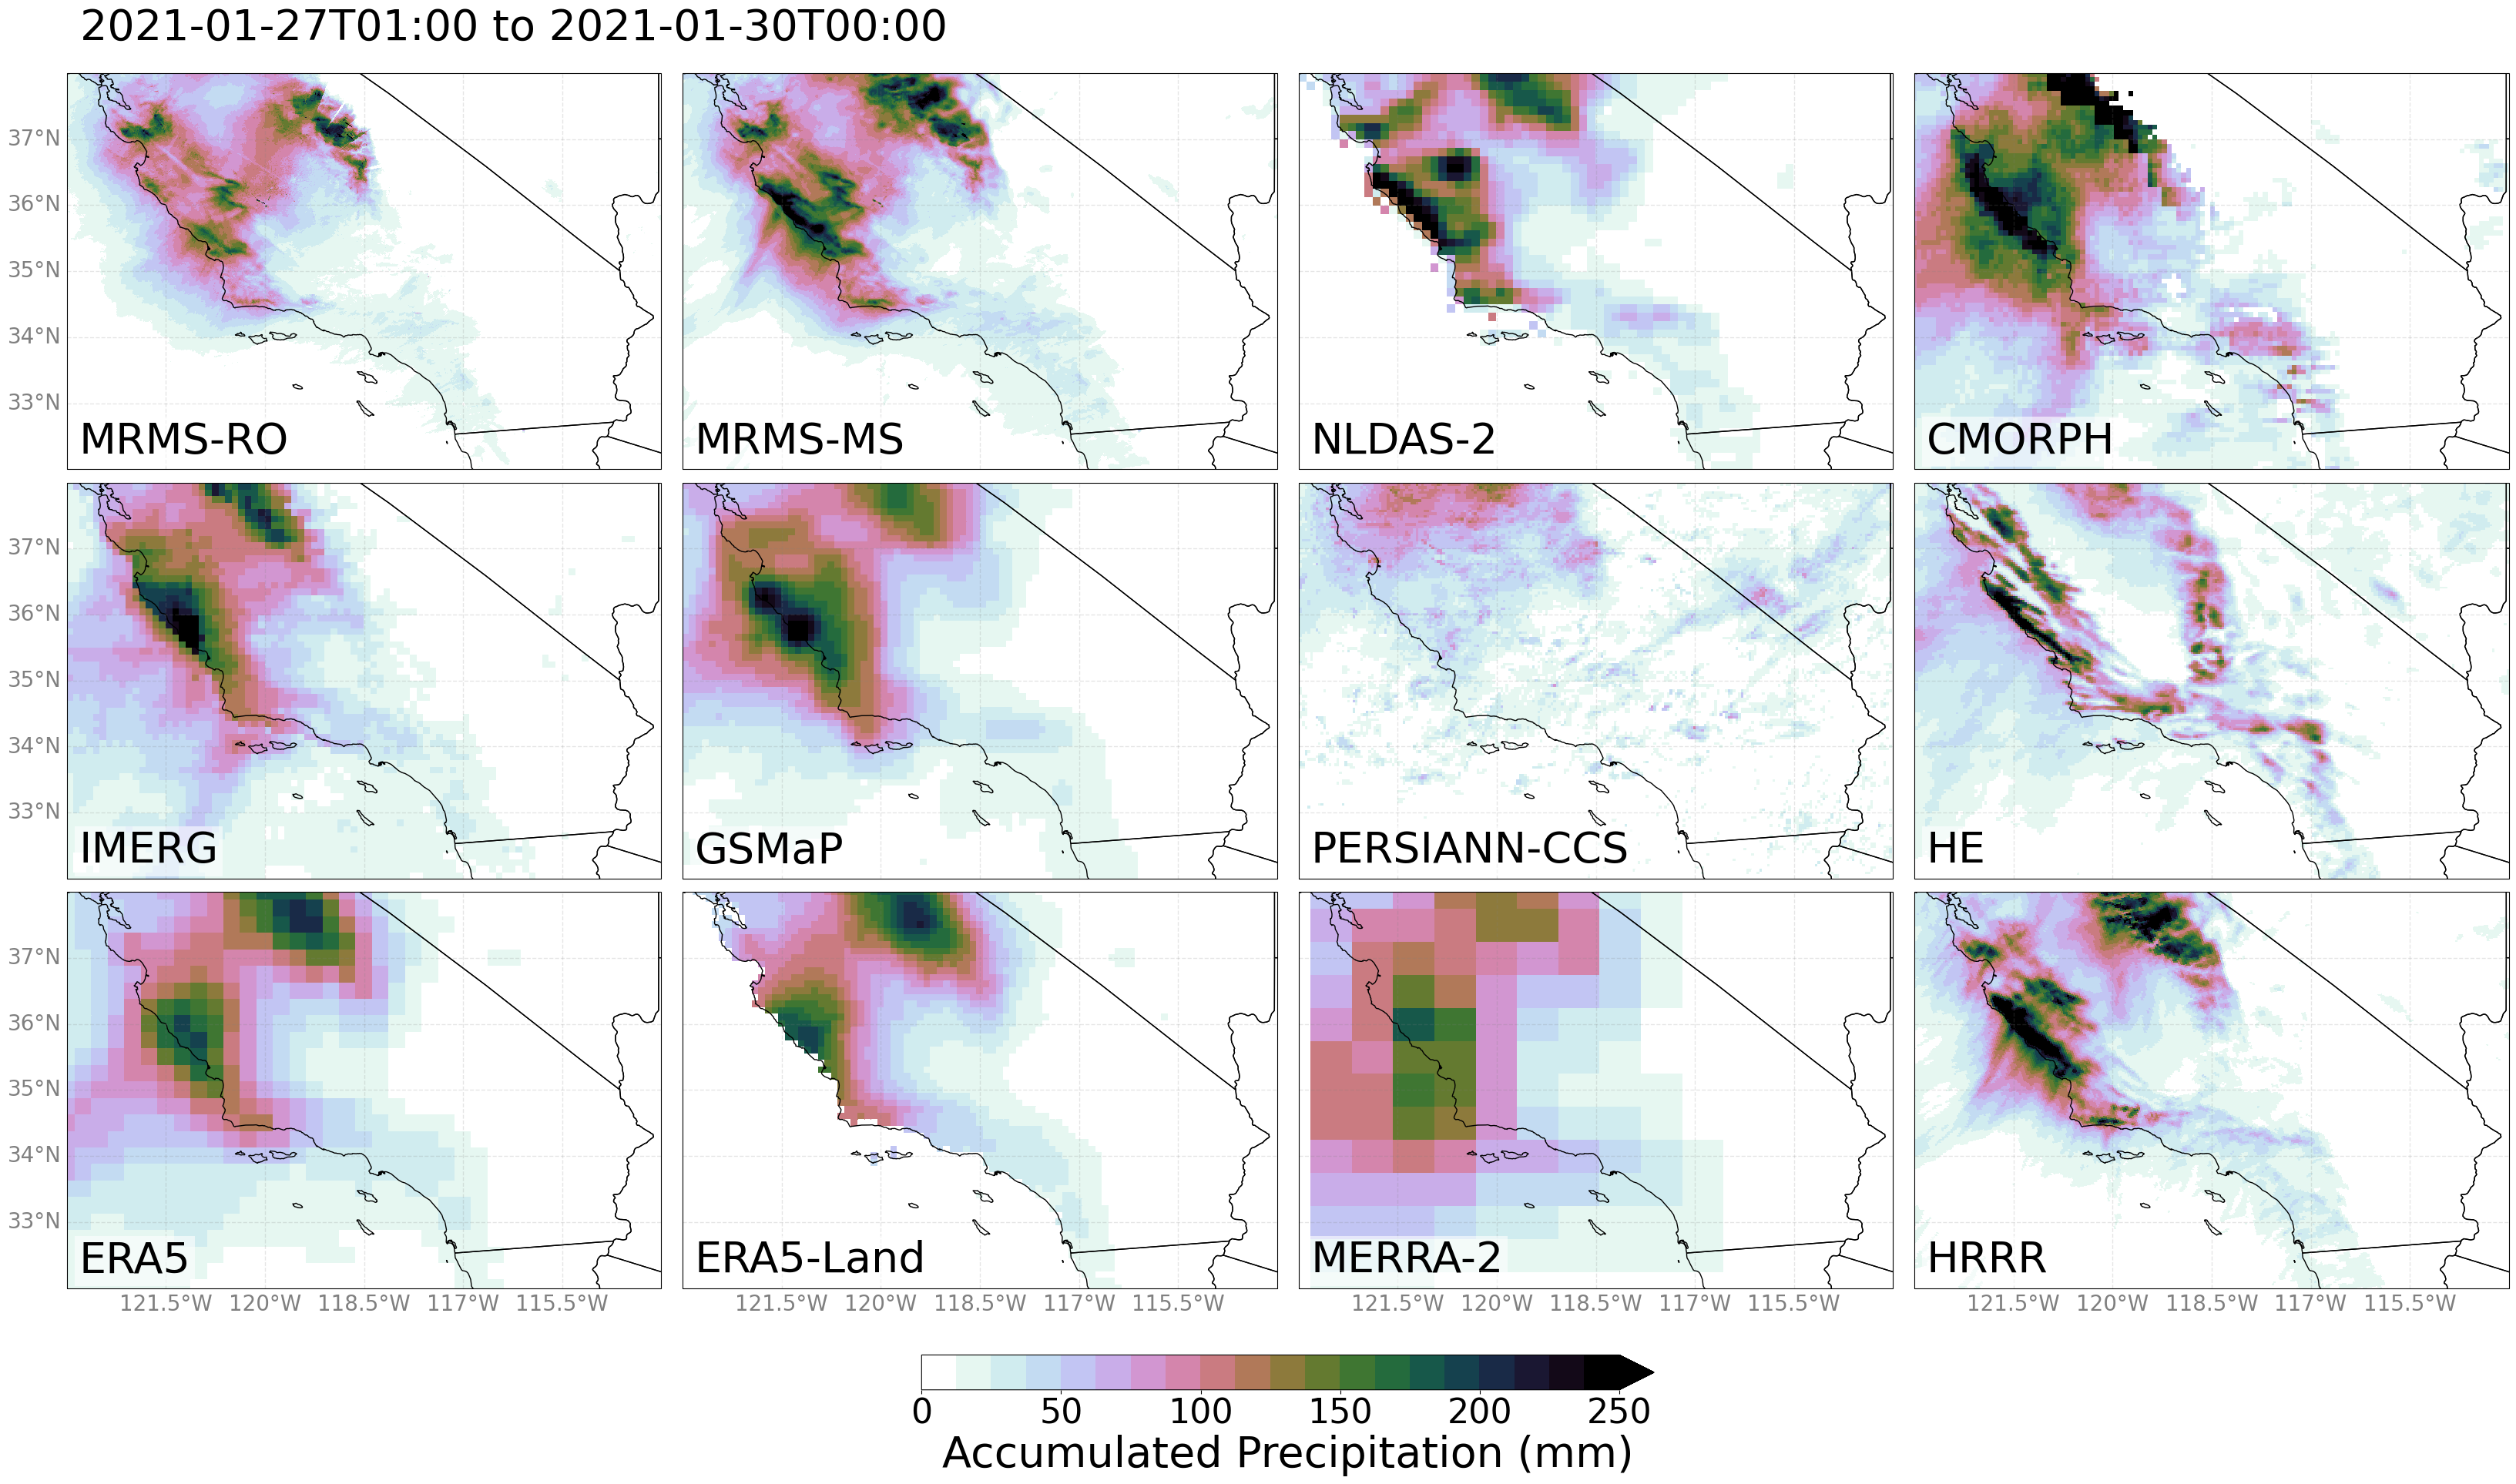

In [10]:
# create figure
fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize, subplot_kw={'projection': projection})
fig.tight_layout(h_pad=2, w_pad=2)

# set up each subplot
for i in range(len(axs.ravel())):
    ax = axs.ravel()[i]    
    ax.add_feature(cartopy.feature.STATES)
    ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())
    
    # add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    if ax not in axs[num_rows-1, :]:
        gl.bottom_labels = False
    if ax not in axs[:, 0]:
        gl.left_labels = False
        
    gl.xlabel_style = {'size': 20, 'color': 'gray'}
    gl.ylabel_style = {'size': 20, 'color': 'gray'}
     
    qpe = qpe_list[i]
    qpe_name = qpe_name_list[i]
    da = globals()[f'{qpe}_da']

    # plot accumulation
    accum_map = ax.pcolormesh(da.lon, da.lat, da.sum(dim='time'), 
                  cmap=plt.get_cmap('cubehelix_r', 20), vmin=0, vmax=accum_max,
                  transform=ccrs.PlateCarree())

    # add label
    ax.annotate(qpe_name, xy=(0.02, 0.04), xycoords='axes fraction', 
               bbox=dict(facecolor='w', edgecolor='none', alpha=0.6), fontsize=40)

# create colorbar
cbar = fig.colorbar(accum_map, ax=axs[:, :], shrink=0.3, extend='max', location='bottom', pad=0.04)
cbar.ax.tick_params(labelsize=32)
cbar.set_label(label='Accumulated Precipitation (mm)', fontsize=40)

# add time label 
fig.suptitle(f'{storm_start} to {storm_end}', x=0.01, y=0.95, ha='left', fontsize=40)

# save figure
if save_accum == True:
    fig.savefig('accumulation_comparison.png', dpi=300, bbox_inches='tight', transparent=True)
    
plt.show()


### plot hourly intensity

in the paper, I used the colormap cmr.torch_r from the cmasher library for intensity plots. I like it better, so if you want to copy what I did, install the cmasher library :)

In [31]:
projection = ccrs.PlateCarree()           # USER INPUT! map projection - I always use platecarree
intensity_max = 40                        # USER INPUT! maximum intensity value to show on color scale
save_intensity = False                    # USER INPUT! whether or not to save figure
num_rows = 3                              # USER INPUT! number of rows in figure
num_cols = 4                              # USER INPUT! number of columns in figure
figsize = (32,22)                         # USER INPUT! figure size

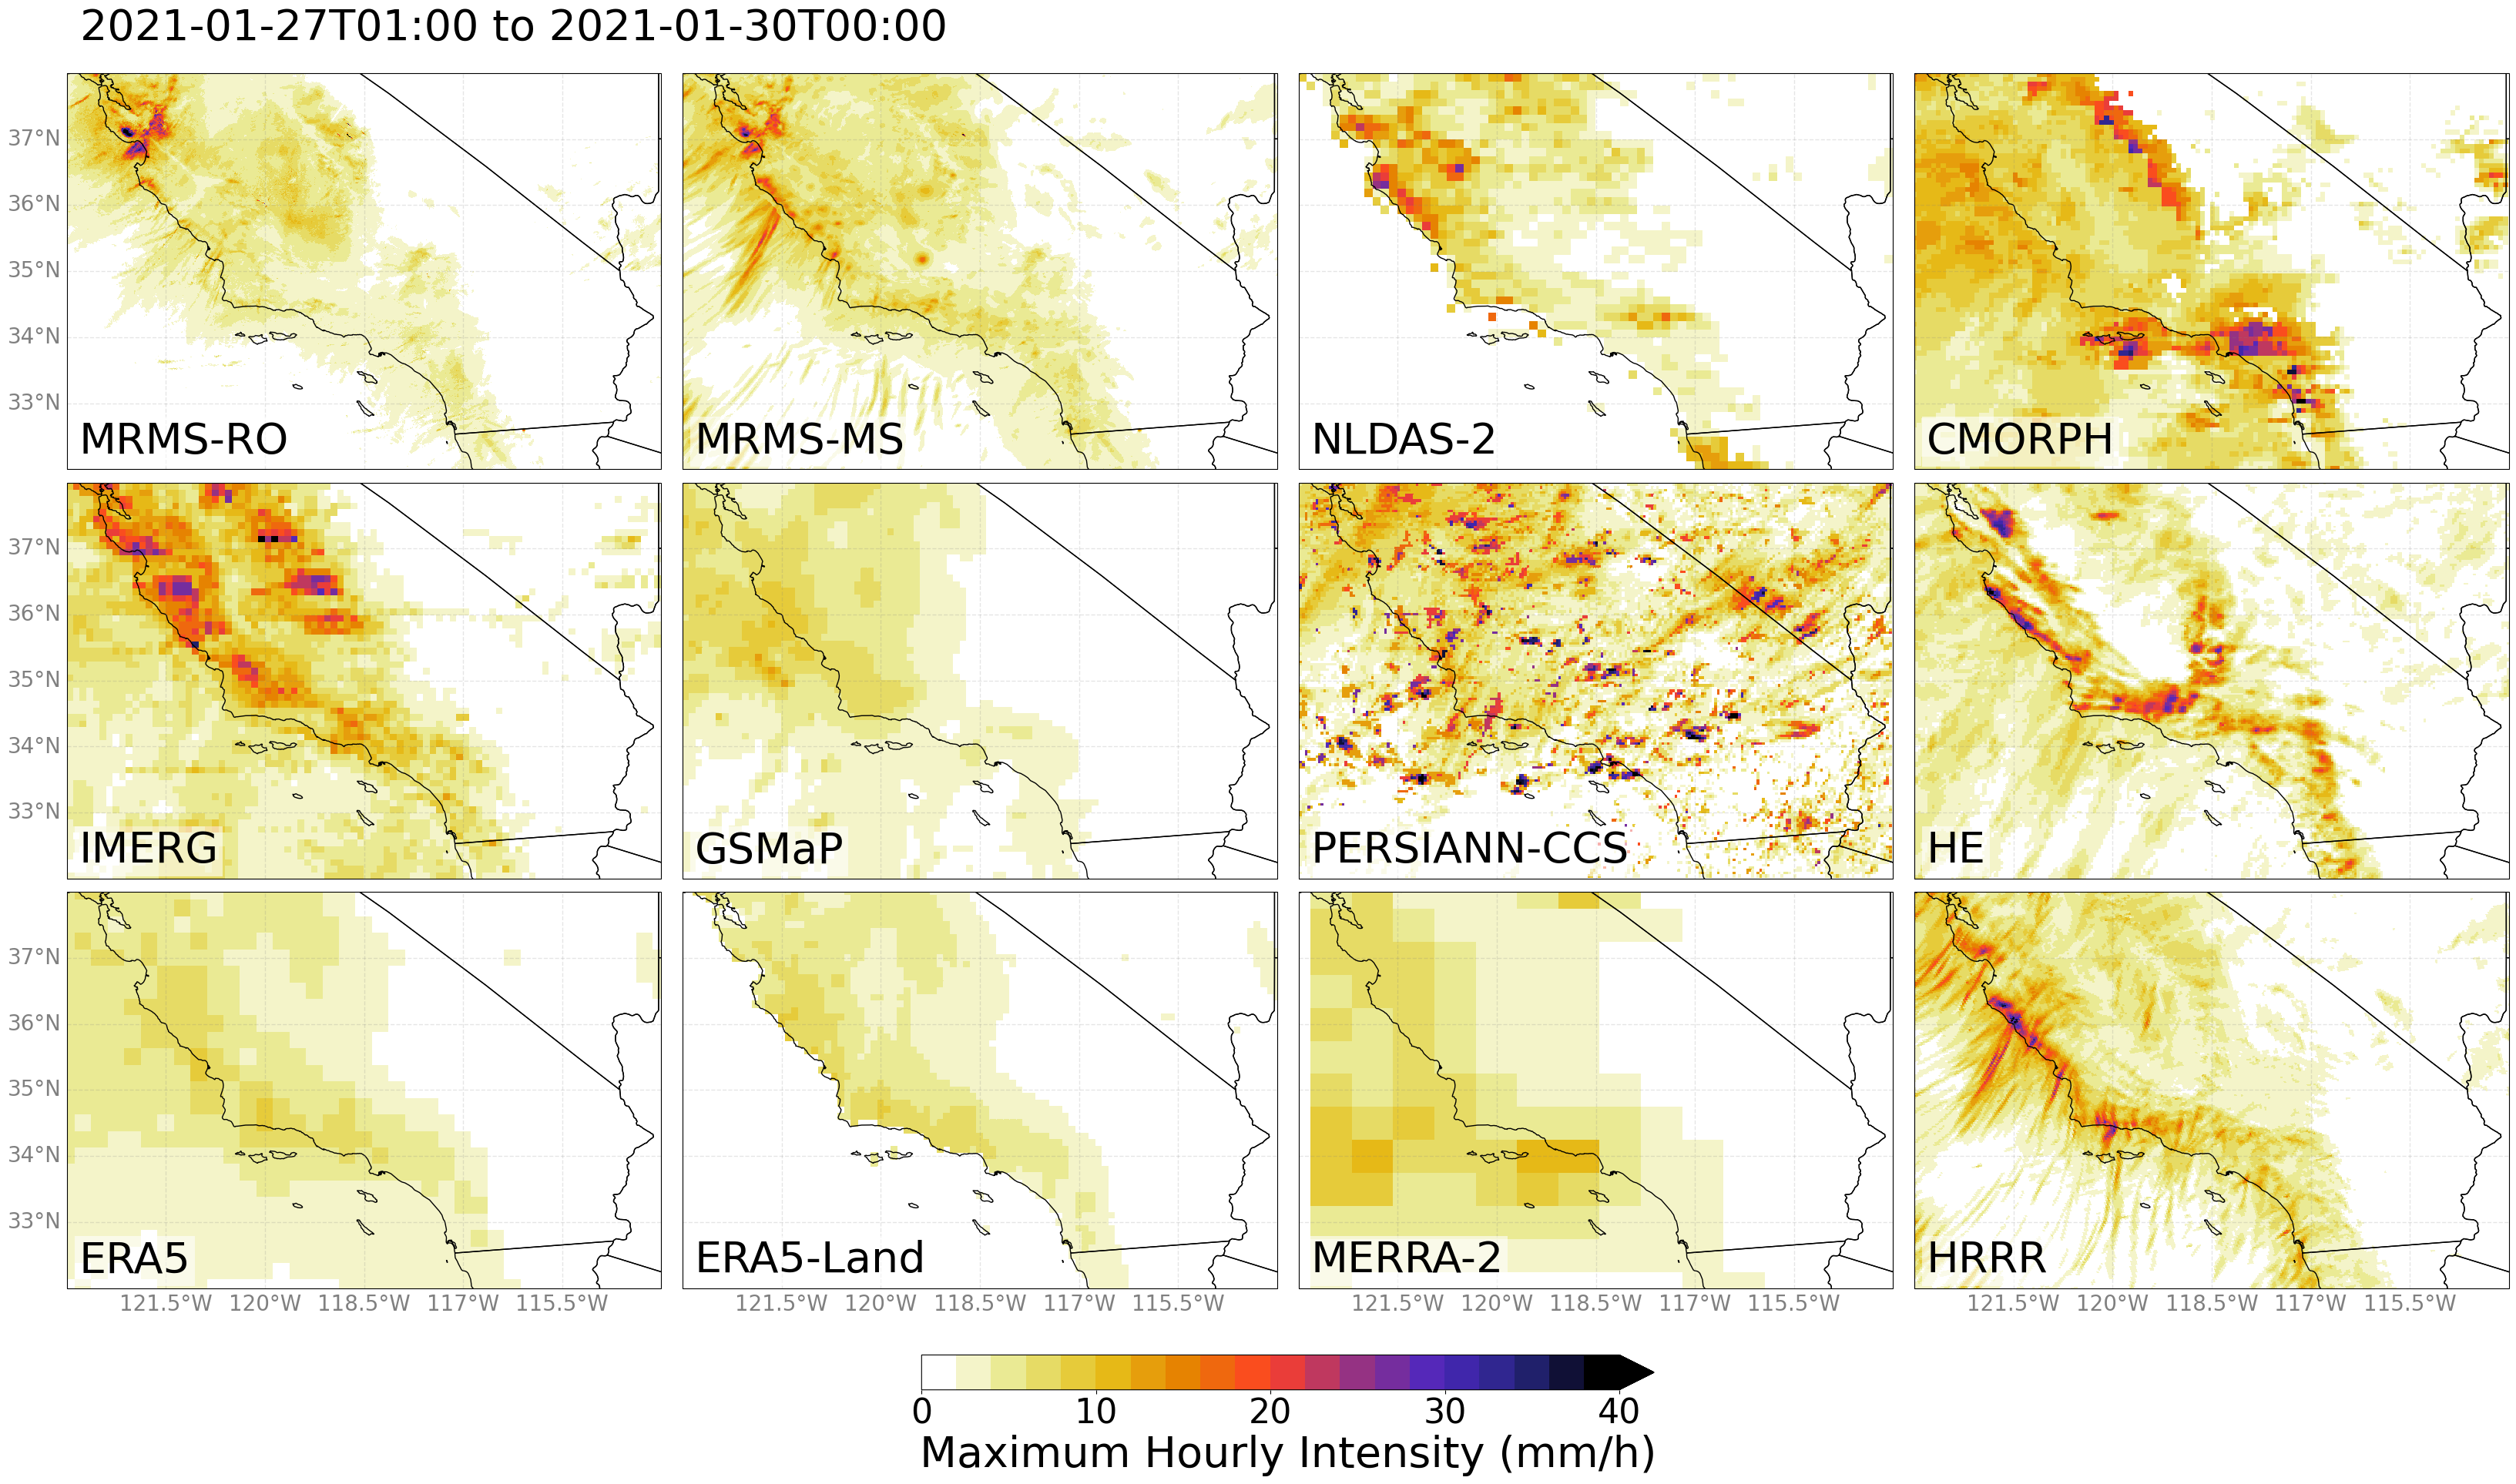

In [38]:
# create figure 
fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize, subplot_kw={'projection': projection})
fig.tight_layout(h_pad=2, w_pad=2)

# set up each subplot
for i in range(len(axs.ravel())):
    ax = axs.ravel()[i]    
    ax.add_feature(cartopy.feature.STATES)
    ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())
    
    # add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    if ax not in axs.ravel()[8:]:
        gl.bottom_labels = False
    if ax not in axs.ravel()[0::4]:
        gl.left_labels = False
        
    gl.xlabel_style = {'size': 20, 'color': 'gray'}
    gl.ylabel_style = {'size': 20, 'color': 'gray'}
    
    qpe = qpe_list[i]
    qpe_name = qpe_name_list[i]
    da = globals()[f'{qpe}_da']

    # plot maximum hourly intensity
    intensity_map = ax.pcolormesh(da.lon, da.lat, da.max(dim='time'), 
                  cmap=plt.get_cmap('CMRmap_r', 20), vmin=0, vmax=intensity_max,
                  transform=ccrs.PlateCarree())

    # add QPE labels
    ax.annotate(qpe_name, xy=(0.02, 0.04), xycoords='axes fraction', 
               bbox=dict(facecolor='w', edgecolor='none', alpha=0.6), fontsize=40)
     
# add colorbar
cbar = fig.colorbar(intensity_map, ax=axs[:, :], shrink=0.3, extend='max', location='bottom', pad=0.04)
cbar.ax.tick_params(labelsize=32)
cbar.set_label(label='Maximum Hourly Intensity (mm/h)', fontsize=40)

# add time label
fig.suptitle(f'{storm_start} to {storm_end}', x=0.01, y=0.95, ha='left', fontsize=40)

# save figure
if save_intensity == True:
    fig.savefig(f'intensity_comparison.png', dpi=300, bbox_inches='tight', transparent=True)
    
plt.show()

### import gauge data

This code assumes gauge data is stored in a netCDF file as shown in gauge_qc.ipynb

Alternatively, you can inport data in a different structure and define the variable 'gauge_totals', 'gauge_maxs', 'gauge_lats', and 'gauge_lons' accordingly

In [20]:
gauge_path = f'{dataset_path}/gauge.nc'#'path/to/gauge_data/gauge.nc'      # USER INPUT! path to cleaned QPE datasets

# open gauge dataset
gauge_ds = xr.open_dataset(gauge_path) 
gauge_ds = gauge_ds.sortby(gauge_ds.total)

# crop to period of interest
gauge_ds_cropped = gauge_ds.sel(time=slice(time_array[0], time_array[-1]))

# define accumulations, max hourly intensities, lats, and lons
gauge_totals = gauge_ds_cropped.precip_int.sum(dim='time')
gauge_maxs = gauge_ds_cropped.precip_int.max(dim='time', skipna=True)
gauge_lats = gauge_ds_cropped.lat.values
gauge_lons = gauge_ds_cropped.lon.values

### plot gauge data

The following plotting code will produce a two-panel figure, showing gauge accumulations on the left and gauge maximum hourly intensities on the right.

In [21]:
projection = ccrs.PlateCarree()           # USER INPUT! map projection - I always use platecarree
save_gauges = False                       # USER INPUT! whether or not to save figure
figsize = (16,8)                          # USER INPUT! figure size

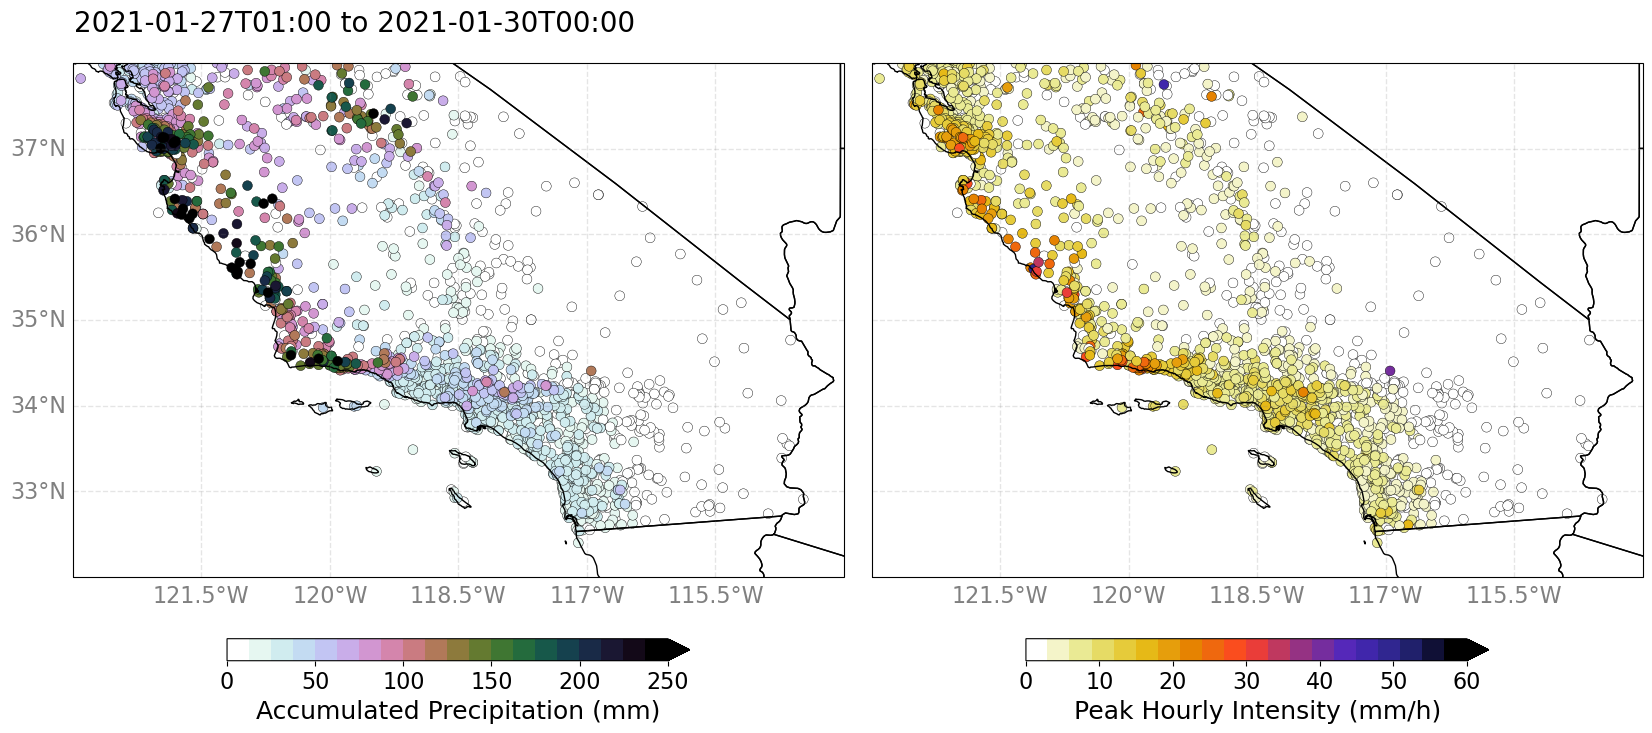

In [25]:
# create figure
fig, axs = plt.subplots(1, 2, figsize=figsize, subplot_kw={'projection': projection})
fig.tight_layout(h_pad=2, w_pad=2)

# set up subplots
for i in range(len(axs.ravel())):
    ax = axs.ravel()[i]    
    ax.add_feature(cartopy.feature.STATES)
    ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())
        
    # add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    if ax not in axs.ravel()[0:1]:
        gl.left_labels = False
        
    gl.xlabel_style = {'size': 16, 'color': 'gray'}
    gl.ylabel_style = {'size': 16, 'color': 'gray'}
        
# plot gauge accumulations
accum_gauge_map = axs[0].scatter(gauge_lons, gauge_lats, c=gauge_totals, 
                                 edgecolors='k', linewidths=0.3,  marker='.', s=200, 
                                 cmap=plt.get_cmap('cubehelix_r', 20), vmin=0, vmax=accum_max,
                                 transform=ccrs.PlateCarree())

# plot gauge intensities
int_gauge_map = axs[1].scatter(gauge_lons, gauge_lats, c=gauge_maxs, 
                               edgecolors='k', linewidths=0.3,  marker='.', s=200, 
                               cmap=plt.get_cmap('CMRmap_r', 20), vmin=0, vmax=intensity_max,
                               transform=ccrs.PlateCarree())

# add accumulation colorbar
cbar_a = fig.colorbar(accum_gauge_map, ax=axs[0:1], shrink=0.6, extend='max', location='bottom', pad=0.08)
cbar_a.ax.tick_params(labelsize=16)
cbar_a.set_label(label='Accumulated Precipitation (mm)', fontsize=18)        

# add intensity colorbar
cbar_i = fig.colorbar(int_gauge_map, ax=axs[1:], shrink=0.6, extend='max', location='bottom', pad=0.08)
cbar_i.ax.tick_params(labelsize=16)
cbar_i.set_label(label='Peak Hourly Intensity (mm/h)', fontsize=18)

# add time label
fig.suptitle(f'{storm_start} to {storm_end}', x=0.01, y=0.95, ha='left', fontsize=20)

# save figure
if save_gauges == True:
    fig.savefig('gauges.png', dpi=300, bbox_inches='tight', transparent=True)
    
plt.show()